In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import zipfile
import shutil
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [5]:
set_seed()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Train samples: 4645, Valid samples: 100


In [6]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def train(num_epochs):
    best_score = -99
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.tight_layout()
        plt.show()

In [66]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()
#         self.block = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(128, 256, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.AdaptiveAvgPool2d((1, 1)))
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
        self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers=2, batch_first=True, bidirectional=True)
        self.avgpool = nn.AvgPool1d(12)
        self.linear = nn.Linear(256, 24)

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 128
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 128
        x, _ = self.lstm(x) # b * 12 * 128
        x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 128
        x = self.linear(x)  # b * 24
        return x

In [67]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [68]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 12.228248M


In [69]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Step: 0, Train Loss: 0.6920665502548218
Step: 20, Train Loss: 0.766789436340332
Step: 40, Train Loss: 0.7465004920959473
Step: 60, Train Loss: 0.8357967138290405
Step: 80, Train Loss: 0.49163803458213806
Step: 100, Train Loss: 0.5556850433349609
Step: 120, Train Loss: 0.48900890350341797
Step: 140, Train Loss: 0.6044503450393677
Epoch: 1, Train loss: 0.5886115127638595
acskill_socre:23.47134029608155, rmse_score:19.27532762036753
Epoch: 1, Valid Score: 4.1960126757140195
Model saved successfully


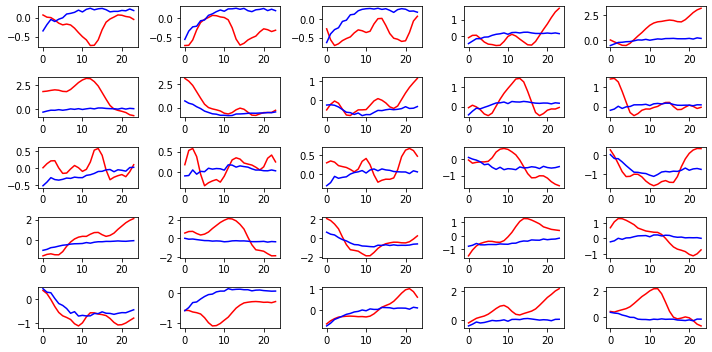

Step: 0, Train Loss: 0.5270015001296997
Step: 20, Train Loss: 0.5766146183013916
Step: 40, Train Loss: 0.37648510932922363
Step: 60, Train Loss: 0.5659770965576172
Step: 80, Train Loss: 0.5098525285720825
Step: 100, Train Loss: 0.4526309669017792
Step: 120, Train Loss: 0.5610626935958862
Step: 140, Train Loss: 0.5962082147598267
Epoch: 2, Train loss: 0.4640572428295057
acskill_socre:20.55921076507851, rmse_score:18.510739638982102
Epoch: 2, Valid Score: 2.048471126096409


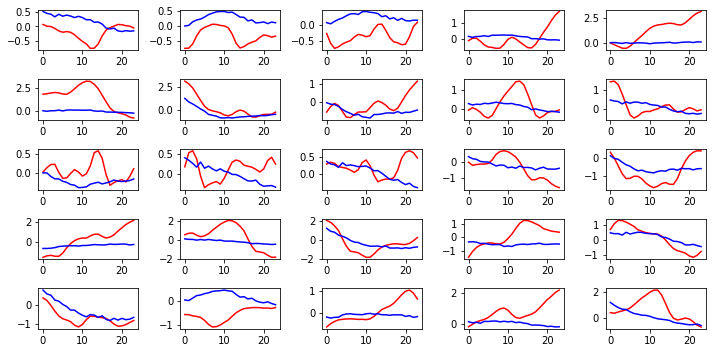

Step: 0, Train Loss: 0.4500690698623657
Step: 20, Train Loss: 0.3494979739189148
Step: 40, Train Loss: 0.35344189405441284
Step: 60, Train Loss: 0.2723913788795471
Step: 80, Train Loss: 0.4388504922389984
Step: 100, Train Loss: 0.44586262106895447
Step: 120, Train Loss: 0.5380270481109619
Step: 140, Train Loss: 0.3864869475364685
Epoch: 3, Train loss: 0.3676692486217577
acskill_socre:24.937039886782003, rmse_score:18.97953739905877
Epoch: 3, Valid Score: 5.957502487723232
Model saved successfully


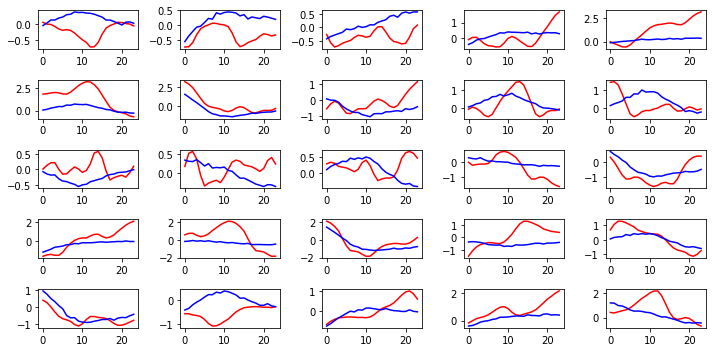

Step: 0, Train Loss: 0.23378871381282806
Step: 20, Train Loss: 0.30905985832214355
Step: 40, Train Loss: 0.2646021246910095
Step: 60, Train Loss: 0.21189755201339722
Step: 80, Train Loss: 0.2263973355293274
Step: 100, Train Loss: 0.2698522210121155
Step: 120, Train Loss: 0.31753331422805786
Step: 140, Train Loss: 0.22150278091430664
Epoch: 4, Train loss: 0.25401709912574455
acskill_socre:21.489152424761375, rmse_score:19.72968731062091
Epoch: 4, Valid Score: 1.7594651141404647


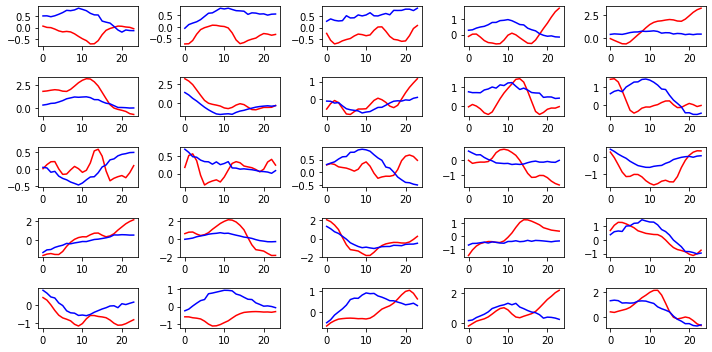

Step: 0, Train Loss: 0.19751960039138794
Step: 20, Train Loss: 0.2763916254043579
Step: 40, Train Loss: 0.1809154450893402
Step: 60, Train Loss: 0.1636868715286255
Step: 80, Train Loss: 0.16794469952583313
Step: 100, Train Loss: 0.1530013531446457
Step: 120, Train Loss: 0.16111963987350464
Step: 140, Train Loss: 0.17907504737377167
Epoch: 5, Train loss: 0.18372574810908265
acskill_socre:28.47929576632744, rmse_score:19.52691066751686
Epoch: 5, Valid Score: 8.95238509881058
Model saved successfully


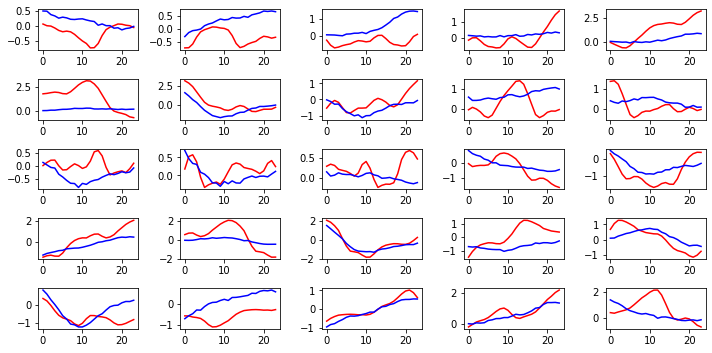

Step: 0, Train Loss: 0.13567838072776794
Step: 20, Train Loss: 0.08895820379257202
Step: 40, Train Loss: 0.12707148492336273
Step: 60, Train Loss: 0.15715008974075317
Step: 80, Train Loss: 0.11583541333675385
Step: 100, Train Loss: 0.11221422255039215
Step: 120, Train Loss: 0.11736834049224854
Step: 140, Train Loss: 0.15035048127174377
Epoch: 6, Train loss: 0.12887217788255378
acskill_socre:22.762903470198623, rmse_score:19.22724738514227
Epoch: 6, Valid Score: 3.5356560850563525


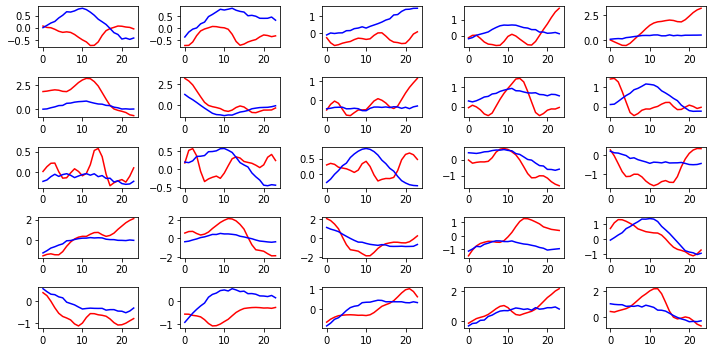

Step: 0, Train Loss: 0.12388309091329575
Step: 20, Train Loss: 0.10551105439662933
Step: 40, Train Loss: 0.10793842375278473
Step: 60, Train Loss: 0.0670466274023056
Step: 80, Train Loss: 0.10952403396368027
Step: 100, Train Loss: 0.10924814641475677
Step: 120, Train Loss: 0.13211502134799957
Step: 140, Train Loss: 0.1000896617770195
Epoch: 7, Train loss: 0.10404310176429683
acskill_socre:27.05108449457561, rmse_score:19.440867763577316
Epoch: 7, Valid Score: 7.610216730998292


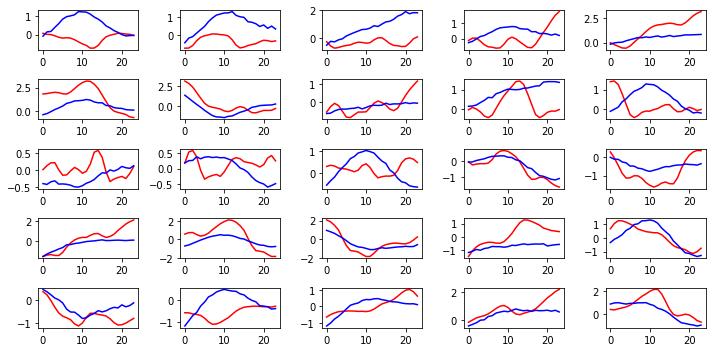

Step: 0, Train Loss: 0.07997633516788483
Step: 20, Train Loss: 0.09472262859344482
Step: 40, Train Loss: 0.11384657025337219
Step: 60, Train Loss: 0.07397603988647461
Step: 80, Train Loss: 0.08396127074956894
Step: 100, Train Loss: 0.15781055390834808
Step: 120, Train Loss: 0.06415778398513794
Step: 140, Train Loss: 0.07878977060317993
Epoch: 8, Train loss: 0.09310672100480288
acskill_socre:25.60567120432779, rmse_score:18.274894594122824
Epoch: 8, Valid Score: 7.330776610204968


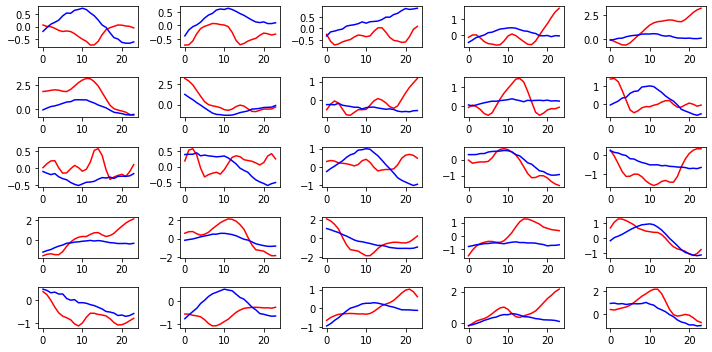

Step: 0, Train Loss: 0.07282453030347824
Step: 20, Train Loss: 0.10187284648418427
Step: 40, Train Loss: 0.11011942476034164
Step: 60, Train Loss: 0.06718370318412781
Step: 80, Train Loss: 0.060698382556438446
Step: 100, Train Loss: 0.08378764241933823
Step: 120, Train Loss: 0.07770402729511261
Step: 140, Train Loss: 0.08954370021820068
Epoch: 9, Train loss: 0.08540459967231097
acskill_socre:23.566483388482556, rmse_score:18.61430285918202
Epoch: 9, Valid Score: 4.952180529300538


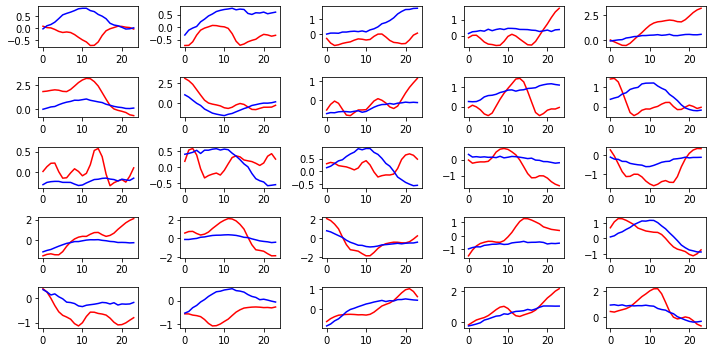

Step: 0, Train Loss: 0.1440405249595642
Step: 20, Train Loss: 0.06131940335035324
Step: 40, Train Loss: 0.07889392971992493
Step: 60, Train Loss: 0.0821092277765274
Step: 80, Train Loss: 0.06949804723262787
Step: 100, Train Loss: 0.12195496261119843
Step: 120, Train Loss: 0.086982361972332
Step: 140, Train Loss: 0.08730768412351608
Epoch: 10, Train loss: 0.08199138531129654
acskill_socre:24.434713428687786, rmse_score:19.804789003376747
Epoch: 10, Valid Score: 4.629924425311039


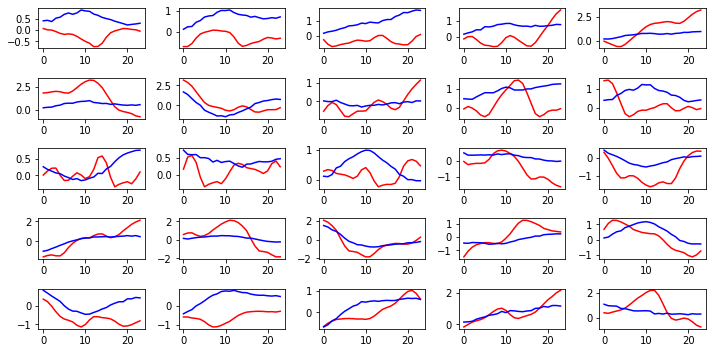

Step: 0, Train Loss: 0.0683274120092392
Step: 20, Train Loss: 0.06916122138500214
Step: 40, Train Loss: 0.09363313019275665
Step: 60, Train Loss: 0.06983541697263718
Step: 80, Train Loss: 0.10042556375265121
Step: 100, Train Loss: 0.08198665082454681
Step: 120, Train Loss: 0.059519022703170776
Step: 140, Train Loss: 0.07907504588365555
Epoch: 11, Train loss: 0.07762951781488445
acskill_socre:23.47036427098959, rmse_score:18.54786317730511
Epoch: 11, Valid Score: 4.922501093684481


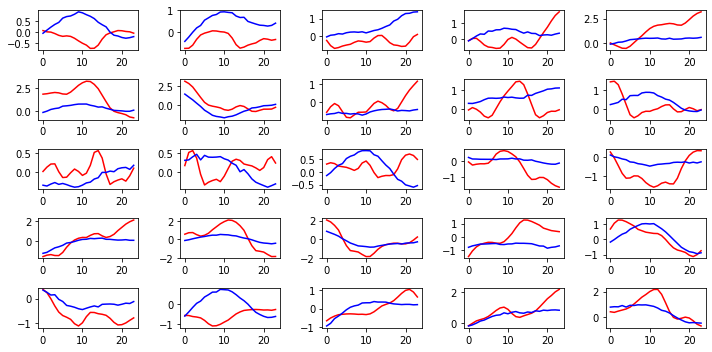

Step: 0, Train Loss: 0.10312658548355103
Step: 20, Train Loss: 0.09357708692550659
Step: 40, Train Loss: 0.05506543442606926
Step: 60, Train Loss: 0.05625725910067558
Step: 80, Train Loss: 0.055600374937057495
Step: 100, Train Loss: 0.04340415447950363
Step: 120, Train Loss: 0.06836161017417908
Step: 140, Train Loss: 0.08295801281929016
Epoch: 12, Train loss: 0.07301413793474028
acskill_socre:25.735782003366754, rmse_score:18.741932920378723
Epoch: 12, Valid Score: 6.9938490829880315


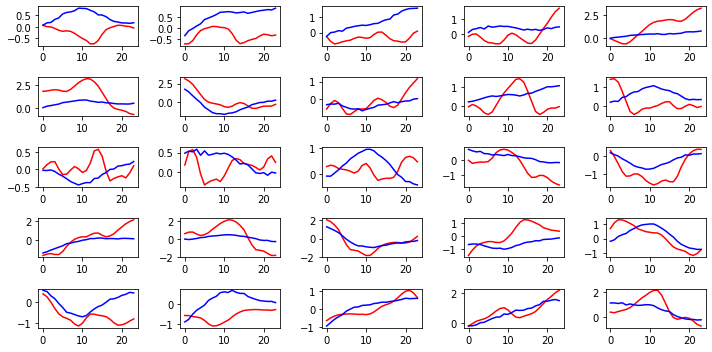

Step: 0, Train Loss: 0.09752967208623886
Step: 20, Train Loss: 0.05419757217168808
Step: 40, Train Loss: 0.060436975210905075
Step: 60, Train Loss: 0.05560341477394104
Step: 80, Train Loss: 0.06460471451282501
Step: 100, Train Loss: 0.06173992156982422
Step: 120, Train Loss: 0.07688342034816742
Step: 140, Train Loss: 0.06559161096811295
Epoch: 13, Train loss: 0.06811515938439598
acskill_socre:26.61355029323603, rmse_score:18.488634015204187
Epoch: 13, Valid Score: 8.124916278031844


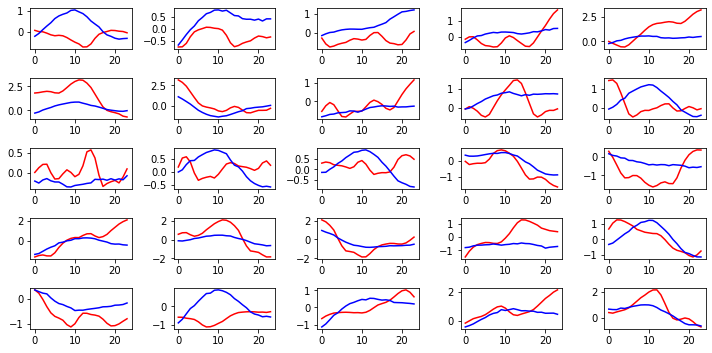

Step: 0, Train Loss: 0.08100748062133789
Step: 20, Train Loss: 0.04786813259124756
Step: 40, Train Loss: 0.08812195062637329
Step: 60, Train Loss: 0.07842814922332764
Step: 80, Train Loss: 0.05308498442173004
Step: 100, Train Loss: 0.07223066687583923
Step: 120, Train Loss: 0.043473683297634125
Step: 140, Train Loss: 0.07162468880414963
Epoch: 14, Train loss: 0.0644044509183054
acskill_socre:27.325776439097666, rmse_score:19.90100647587643
Epoch: 14, Valid Score: 7.424769963221237


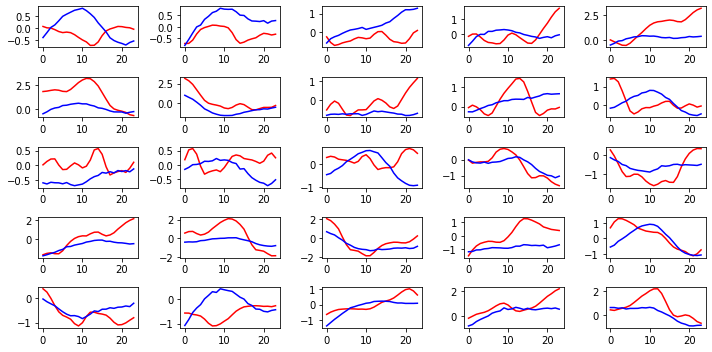

Step: 0, Train Loss: 0.0457482747733593
Step: 20, Train Loss: 0.10117851197719574
Step: 40, Train Loss: 0.06316877901554108
Step: 60, Train Loss: 0.07176663726568222
Step: 80, Train Loss: 0.06630261987447739
Step: 100, Train Loss: 0.0566721074283123
Step: 120, Train Loss: 0.07399820536375046
Step: 140, Train Loss: 0.055177778005599976
Epoch: 15, Train loss: 0.06786559103694681
acskill_socre:26.75488070281903, rmse_score:20.379753300198093
Epoch: 15, Valid Score: 6.375127402620937


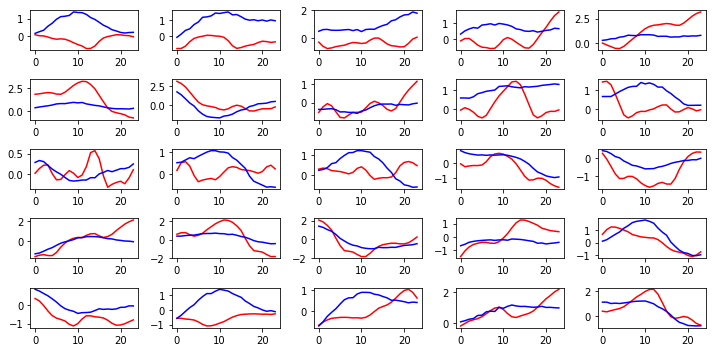

Step: 0, Train Loss: 0.05365345627069473
Step: 20, Train Loss: 0.055949777364730835
Step: 40, Train Loss: 0.0964587926864624
Step: 60, Train Loss: 0.0784551128745079
Step: 80, Train Loss: 0.04507863149046898
Step: 100, Train Loss: 0.052812524139881134
Step: 120, Train Loss: 0.04895281046628952
Step: 140, Train Loss: 0.08230988681316376
Epoch: 16, Train loss: 0.0619376693431237
acskill_socre:24.119793709255678, rmse_score:19.1008352373456
Epoch: 16, Valid Score: 5.018958471910079


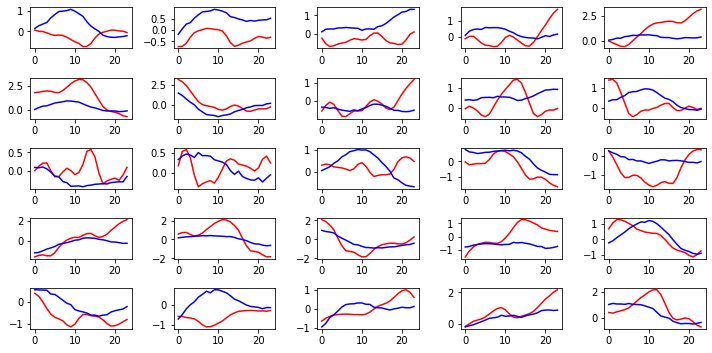

Step: 0, Train Loss: 0.06251421570777893
Step: 20, Train Loss: 0.06551651656627655
Step: 40, Train Loss: 0.05400233715772629
Step: 60, Train Loss: 0.04067596048116684
Step: 80, Train Loss: 0.04394787177443504
Step: 100, Train Loss: 0.04608382284641266
Step: 120, Train Loss: 0.054641108959913254
Step: 140, Train Loss: 0.05059889703989029
Epoch: 17, Train loss: 0.052846076056259135
acskill_socre:25.21698215065114, rmse_score:19.137471648642745
Epoch: 17, Valid Score: 6.079510502008397


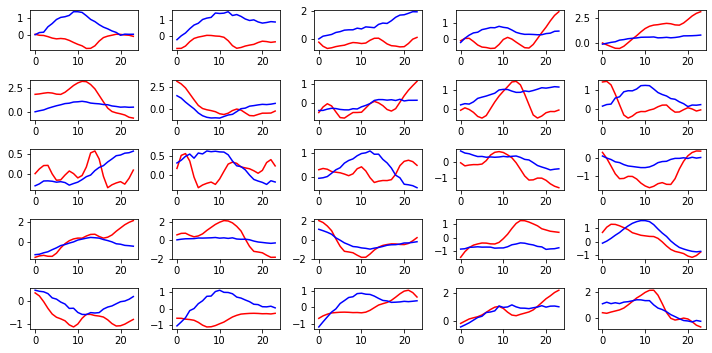

Step: 0, Train Loss: 0.05126897618174553
Step: 20, Train Loss: 0.0456969290971756
Step: 40, Train Loss: 0.03944876417517662
Step: 60, Train Loss: 0.04763836786150932
Step: 80, Train Loss: 0.05801013112068176
Step: 100, Train Loss: 0.06715844571590424
Step: 120, Train Loss: 0.036285679787397385
Step: 140, Train Loss: 0.04287146031856537
Epoch: 18, Train loss: 0.05031938746265353
acskill_socre:25.922928808501243, rmse_score:18.066650514190865
Epoch: 18, Valid Score: 7.856278294310378


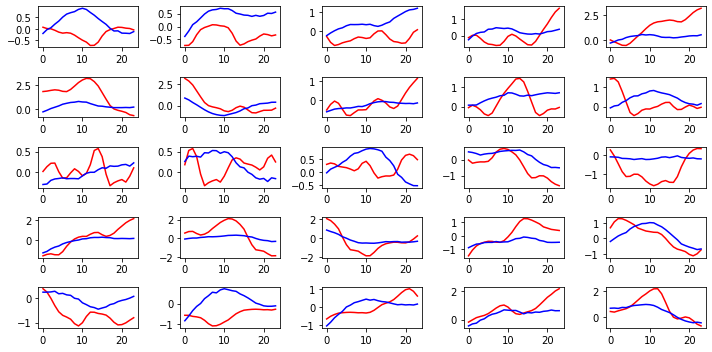

Step: 0, Train Loss: 0.04272013530135155
Step: 20, Train Loss: 0.05112394690513611
Step: 40, Train Loss: 0.07078460603952408
Step: 60, Train Loss: 0.10886862128973007
Step: 80, Train Loss: 0.044468045234680176
Step: 100, Train Loss: 0.04643189162015915
Step: 120, Train Loss: 0.04676024243235588
Step: 140, Train Loss: 0.05456726998090744
Epoch: 19, Train loss: 0.051266531842722465
acskill_socre:27.482100522912422, rmse_score:18.896297975330018
Epoch: 19, Valid Score: 8.585802547582404


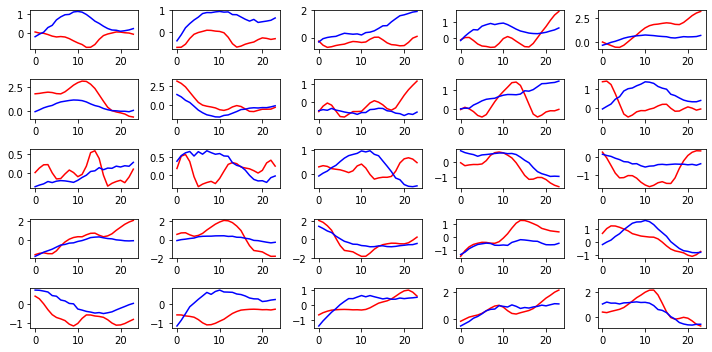

Step: 0, Train Loss: 0.06466378271579742
Step: 20, Train Loss: 0.07433023303747177
Step: 40, Train Loss: 0.044234078377485275
Step: 60, Train Loss: 0.04302617907524109
Step: 80, Train Loss: 0.037080369889736176
Step: 100, Train Loss: 0.046765439212322235
Step: 120, Train Loss: 0.05711628496646881
Step: 140, Train Loss: 0.02786804735660553
Epoch: 20, Train loss: 0.04773370754484036
acskill_socre:24.906371176572183, rmse_score:18.35087660471395
Epoch: 20, Valid Score: 6.555494571858233


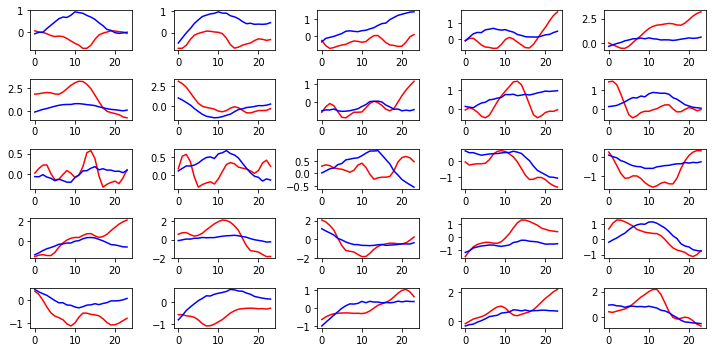

Step: 0, Train Loss: 0.06537147611379623
Step: 20, Train Loss: 0.035726647824048996
Step: 40, Train Loss: 0.048261504620313644
Step: 60, Train Loss: 0.03371506929397583
Step: 80, Train Loss: 0.034240491688251495
Step: 100, Train Loss: 0.06280626356601715


In [ ]:
train(num_epochs=30)

In [94]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

<All keys matched successfully>

In [7]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [8]:
### 2. predict
test_predicts_dict = {}
for file_name,val in test_feas_dict.items():
    SST = torch.tensor(val[:,:,:,0]).unsqueeze(0).to(device).float()
    T300 = torch.tensor(val[:,:,:,1]).unsqueeze(0).to(device).float()
    Ua = torch.tensor(val[:,:,:,2]).unsqueeze(0).to(device).float()
    Va = torch.tensor(val[:,:,:,3]).unsqueeze(0).to(device).float()
    test_predicts_dict[file_name] = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
#     test_predicts_dict[file_name] = model.predict(val.reshape([-1,12])[0,:])

In [9]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [44]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [45]:
make_zip()

./result/test_0144-01-12.npy
